In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import plotly
from plotly.offline import init_notebook_mode
import plotly.express as px
import scipy
from scipy import stats
import seaborn as sns
import sys
import sklearn
from sklearn import decomposition
from sklearn.metrics.cluster import adjusted_rand_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans




In [217]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 100)

# Versions
print('Version des librairies utilisées :')

print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Plotly                : ' + plotly.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)

Version des librairies utilisées :
NumPy                 : 1.20.1
Pandas                : 1.2.4
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Plotly                : 5.1.0
Seaborn               : 0.12.2
Sklearn               : 1.2.1


In [218]:
df = pd.read_csv('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P5\\maint.csv')

In [219]:
df.head()

,customer_unique_id,score,order_purchase_timestamp,recency,frequency,monetary_value
0,861eff4711a542e4b93843c6dd7febb0,4.0,2017-05-16 15:05:35,469,1,124.99
1,290c77bc529b7ac935b93aa66c333dc3,5.0,2018-01-12 20:48:24,228,1,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,5.0,2018-05-19 16:07:45,101,1,139.94
3,259dac757896d24d7702b9acbbff3f3c,5.0,2018-03-13 16:06:38,168,1,149.94
4,345ecd01c38d18a9036ed96c73b8d066,5.0,2018-07-29 09:51:30,31,1,230.00


In [220]:
df.drop("customer_unique_id", axis = 1,inplace = True)

In [221]:
print("Date du dernier achat", df.order_purchase_timestamp.max())
print("Date du premier achat", df.order_purchase_timestamp.min())

Date du dernier achat 2018-08-29 15:00:37
Date du premier achat 2016-10-03 09:44:50


In [222]:
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(pd.to_datetime, format='%Y-%m-%d')

In [223]:
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].apply(lambda x: x.date())

In [224]:
df.head()

,score,order_purchase_timestamp,recency,frequency,monetary_value
0,4.0,2017-05-16,469,1,124.99
1,5.0,2018-01-12,228,1,289.00
2,5.0,2018-05-19,101,1,139.94
3,5.0,2018-03-13,168,1,149.94
4,5.0,2018-07-29,31,1,230.00


Initialisation avec 6 mois de données.

Période T0 = 6 mois

In [312]:
# on garde uniquement les lignes dont la date est comprise entre date.min() et date.min() + 6 mois
X = df[df['order_purchase_timestamp'] <= (df['order_purchase_timestamp'].min() + DateOffset(months=6))]

In [313]:
X = X.drop("order_purchase_timestamp", axis = 1)

In [314]:
#standardisation
scaler = StandardScaler()
X_scaled = pd.DataFrame(data= scaler.fit_transform(X), columns = X.columns)

In [315]:
### afficher les 5 eres valeurs du dataframe centré et réduit
X_scaled.head()

,score,recency,frequency,monetary_value
0,0.665568,0.515683,-0.413775,0.208107
1,-0.119318,-0.520179,-0.413775,-0.123572
2,-0.119318,-0.350112,0.388879,-0.473961
3,-0.119318,-0.350112,0.388879,-0.473961
4,0.665568,-0.257348,-0.413775,-0.512616


In [316]:
#analyse en composantes principales pour réduction
pca_ini = decomposition.PCA(random_state = 42)
pca_ini.fit(X_scaled)
projected_ini = pca_ini.transform(X_scaled)

In [317]:
projected_ini

array([[-0.45758831,  0.31218592,  0.78280725,  0.0615989 ],
       [-0.17304072,  0.25464704, -0.49002559,  0.36931006],
       [ 0.11107595, -0.00980364, -0.5608995 , -0.43085889],
       ...,
       [-0.1861957 , -2.24109275, -0.93722138,  0.88616046],
       [-0.24487863,  0.19146518, -0.45953549,  0.31207941],
       [-0.24992635, -0.55813718, -0.76783301,  0.46873745]])

In [318]:
#on récupère les 3 eres composantes principales
X_scaled["PC1"] = projected_ini[:,0]
X_scaled["PC2"] = projected_ini[:,1]
X_scaled["PC3"] = projected_ini[:,2]


In [319]:
X_scaled_pca_ini = X_scaled[['PC1','PC2','PC3']]

In [320]:
X_scaled_pca_ini

,PC1,PC2,PC3
0,-0.457588,0.312186,0.782807
1,-0.173041,0.254647,-0.490026
2,0.111076,-0.009804,-0.560900
3,0.111076,-0.009804,-0.560900
4,-0.658456,0.668349,-0.157265
...,...,...,...
6185,-0.593535,0.714099,-0.162981
6186,-0.440305,0.149826,-0.627212
6187,-0.186196,-2.241093,-0.937221
6188,-0.244879,0.191465,-0.459535


In [321]:
def calc_period(data, nbdays):
    '''
    Fonction qui crée un dataframe avec 6 mois + nbdays de données
        Paramètre : 
            data : dataframe 
            nbdays : entier, nombre de jours à ajouter à 365 jours
        Sortie : Dataframe de données sur l'intervalle de temps voulu
        
    '''
    return data[data.order_purchase_timestamp <= (data.order_purchase_timestamp.min() + DateOffset(days=365+nbdays))]

In [322]:
def std_pca_data(df):
    '''
    Fonction qui standardise puis initie une ACP et réduit à 4 composantes un Dataframe
        Paramètres : 
            df : Dataframe 
        Sortie : 
            Dataframe standardisé et projeté sur ses 4 premières composantes principales 
    '''
    df = df.drop("order_purchase_timestamp", axis = 1)
    #standardisation
    ss = StandardScaler()
    df_scaled = pd.DataFrame(data= ss.fit_transform(df), columns = df.columns)
    #analyse en composantes principales pour réduction
    pca = decomposition.PCA(random_state = 42)
    pca.fit(df_scaled)
    projected = pca.transform(df_scaled)
    #on récupère les 4 eres composantes principales
    df_projected = pd.DataFrame()
    df_projected["PC1"] =projected[:,0]
    df_projected["PC2"] = projected[:,1]
    df_projected["PC3"] = projected[:,2]
    
    
   
    
    return   df_projected, df_scaled   

In [308]:
def calcKmeans(df_pca): 
    '''
    Applique la segmentation K-means sur un dataframe
    
        Paramètres : 
            df_pca: dataframe  à segmenter
        Sortie : 
            Liste des clusters calculés
    '''
    kmeans = KMeans(n_clusters = 5, random_state = 1).fit(df_pca)
    
    cluster_labels = kmeans.labels_
    df_pca_km = df_pca.assign(Cluster = cluster_labels)
    return  cluster_labels

In [309]:
ari_score = []

  
for i in range(0,360,20):
    
    df_projected_i, df_scaled_i = std_pca_data(calc_period(df, i))


    #On applique la PCA initial sur la nouvelle période
    projected_i0 = pca0.transform(df_scaled_i)
    #on récupère les 3 eres composantes principales
    df_projected_i0 = pd.DataFrame()
    df_projected_i0["PC1"] =projected_i0[:,0]
    df_projected_i0["PC2"] = projected_i0[:,1]
    df_projected_i0["PC3"] = projected_i0[:,2]
    
    
    ari_i = adjusted_rand_score(calcKmeans(df_projected_i0),calcKmeans(df_projected_i))
    
    ari_score.append([i,ari_i])

In [310]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"] )
ari_score

,periode,ARI
0,0,1.000000
1,20,0.994622
2,40,0.989944
3,60,0.982940
4,80,0.972245
5,100,0.970271
6,120,0.977001
7,140,0.972480
8,160,0.966358
9,180,0.968652


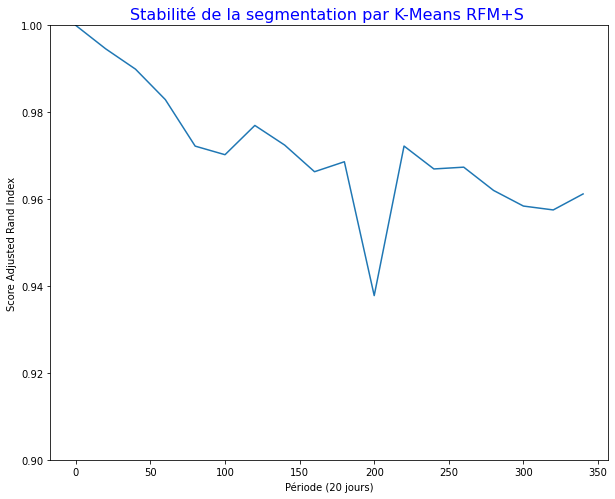

In [311]:
#afficher  ARI Score
fig = plt.figure(figsize=(10,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Période (20 jours)")
plt.ylabel("Score Adjusted Rand Index")
plt.title("Stabilité de la segmentation par K-Means RFM+S ",
          fontsize=16,
          color="b")
plt.ylim(0.9,1)
plt.show()
